# PS reconstruction slice emittance example

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
p0c = 10.0e6
data_dir = os.path.join('data','eex_beam')
gt_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms.yaml'),
    p0c = p0c,
#    save_as = os.path.join('gt_beam.pt'),
    n_particle=10000
)

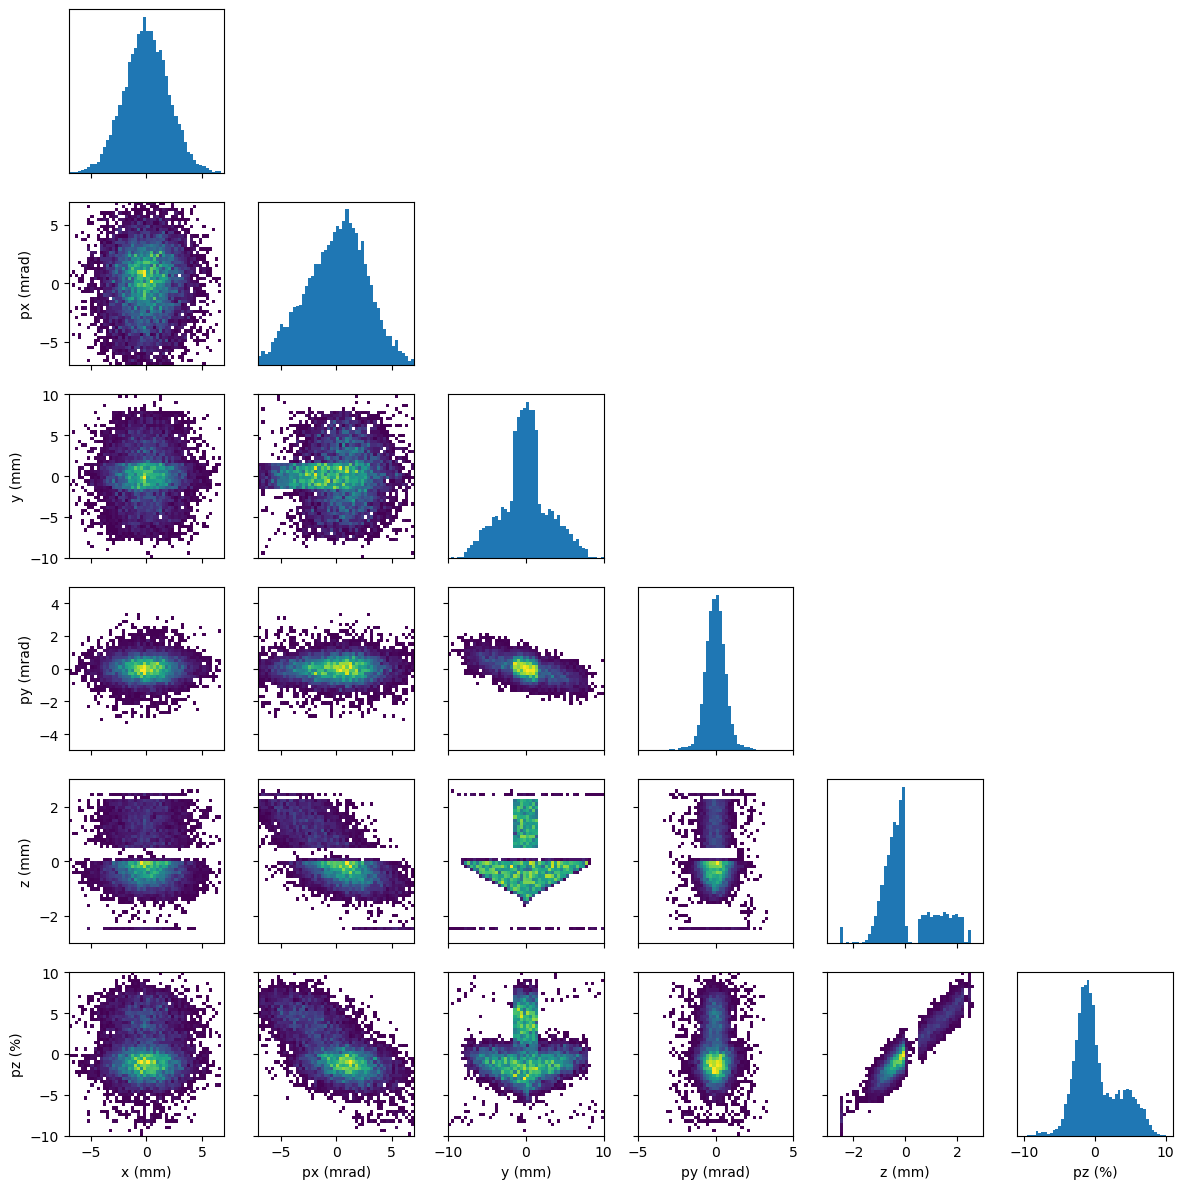

In [3]:
#plot gt beam
lims = np.array([[-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-10e-3, 10e-3],
                 [-5e-3, 5e-3],
                 [-3e-3, 3e-3],
                 [-10e-2, 10e-2]])

# swap x-z distributions
data = gt_beam.data.clone()
data = torch.index_select(data, -1, torch.tensor([4,1,2,3,0,5]))
gt_beam.data = data

fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims=lims,
    background = 1
)



plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 = 7.570125
k2 = -15.704693
k3 = 1.0

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
#lattice.elements[0].K1.data = torch.tensor(k1)
#lattice.elements[2].K1.data = torch.tensor(k2)
#lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 7
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-60, 60, 150) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 7, 2, 2])
torch.Size([3, 7, 2, 2, 1])


## Complete 3D scan training data

In [6]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
#    save_as = '3d_scan_train.dset'
)

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

torch.Size([28, 3, 1])
torch.Size([28, 1, 150, 150])


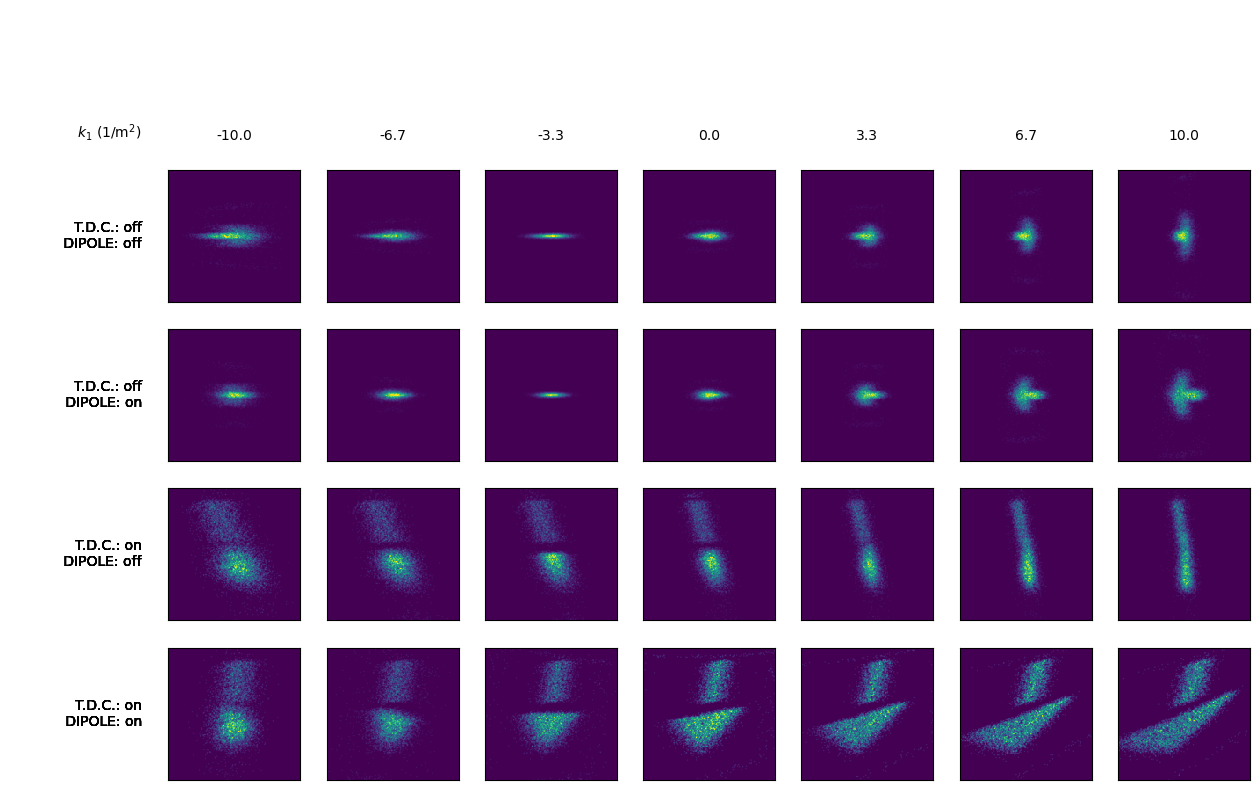

In [7]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

### 10,000 particles, multi-GPU

In [8]:
%%time

pred_beam_3d_scan_10_000 = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1000,
    n_particles = 100_000, 
    device = 'cuda:0'
    )

Using device: cuda:0


/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4353653., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(1810587., device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(1203364.6250, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(1454289.5000, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(1173493.8750, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(1058406.7500, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(1131511.5000, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(1189373.6250, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(1072792.7500, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(1121322.3750, device='cuda:0', grad_fn=<MulBackward0>)
CPU times: user 4min 20s, sys: 1min 11s, total: 5min 31s
Wall time: 5min 32s


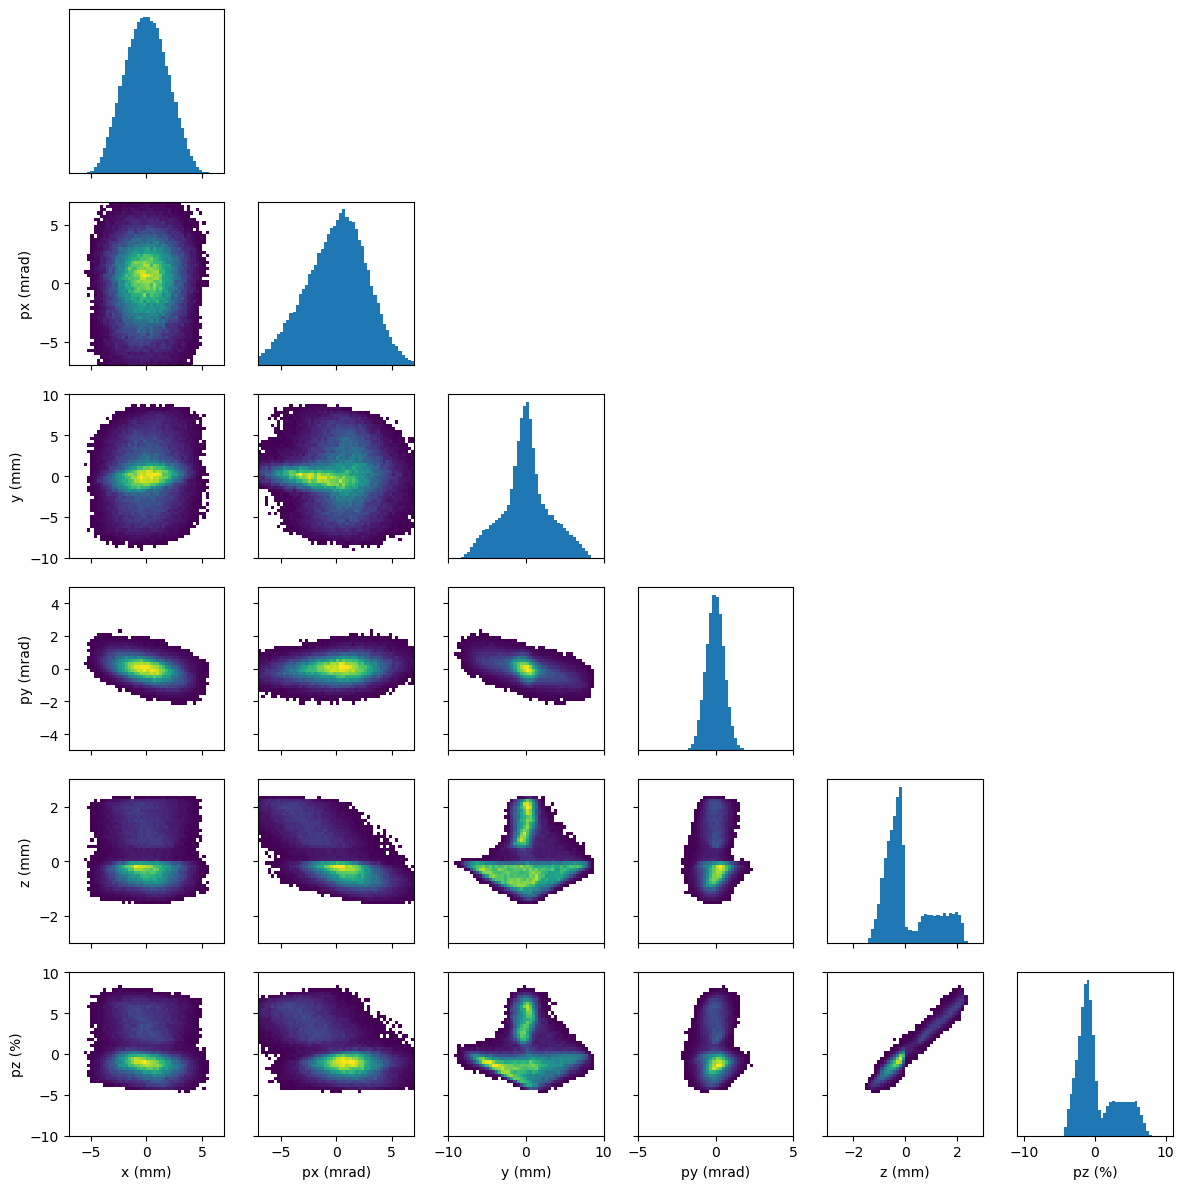

In [9]:
# reconstructed beam projections:

fig, ax = plot_projections(
    pred_beam_3d_scan_10_000.numpy_particles(),
    custom_lims=lims,
    background = 1
)

In [10]:
torch.cuda.empty_cache()

In [11]:
%%time

pred_beam_3d_scan_10_000 = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 2000,
    n_particles = 100_000, 
    device = 'cuda:0'
    )

Using device: cuda:0
0 tensor(4547606., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(1497807.5000, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(1344578.2500, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(1215207.5000, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(1324823.7500, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(1416370.8750, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(1239313.6250, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(1153192.1250, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(1102335.8750, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(1120872.5000, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(943045.1875, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(1248026.8750, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(1195042.8750, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(1305265., device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(1262055.2500, device='cuda:0', grad_fn=<MulBackwar

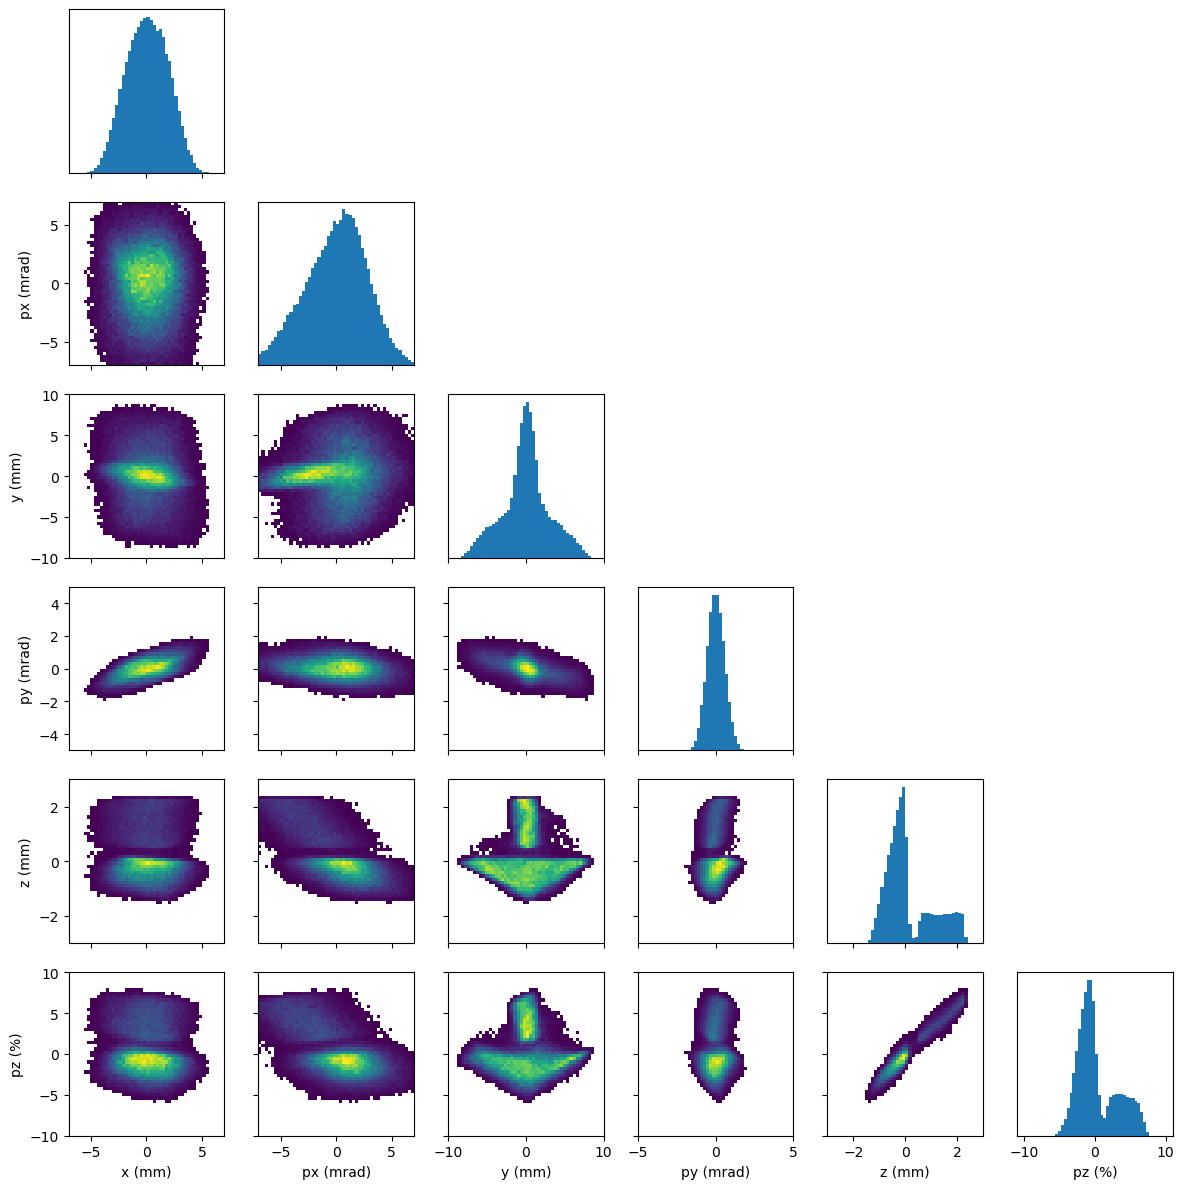

In [12]:
# reconstructed beam projections:

fig, ax = plot_projections(
    pred_beam_3d_scan_10_000.numpy_particles(),
    custom_lims=lims,
    background = 1
)